In [1]:
%matplotlib inline
%pylab inline
pylab.rcParams['figure.figsize'] = (10.0, 8.0)

import geopandas as gpd
import pandas as pd
import glob
import zipfile
import rasterio
import os
import xarray as xr
import json
from rasterstats import zonal_stats
from rasterio.transform import from_origin


# gpd.version.version

Populating the interactive namespace from numpy and matplotlib


# Open Gridmet max temperature with geopandas and plot

In [3]:
print(os.getcwd())
from pathlib import Path
folder = Path(r'../Data_v1_1') # assumes working directory is onhm-fetcher-parser
print(folder)
# shapefiles = folder.glob("*_0[1-2].shp")
shapefiles = folder.glob("*.shp")
gdf = pd.concat([
    gpd.read_file(shp)
    for shp in shapefiles
]).pipe(gpd.GeoDataFrame)
gdf.reset_index(drop=True, inplace=True)
# gdf.plot()
#print(gdf)

B:\GitRepos\onhm-fetcher-parser\notebooks
..\Data_v1_1


# Open Gridmet data (as netcdf file) and save as geotiff raster
This first bit of code follows examples from the following link:https://climate.northwestknowledge.net/MACA/OPENDAP.php
First we open the data set and inspect the metadata

In [4]:
import requests
from requests.exceptions import HTTPError

# delete existing file if it exists
exists = os.path.isfile(r'../Data/test3.nc')
if exists:
#     ds.close()
    os.remove(r'../Data/test3.nc')
    print('removed existing file')

# Url for non-aggragated
url = r'http://thredds.northwestknowledge.net:8080/thredds/ncss/MET/tmmn/tmmn_2019.nc'
payload={'var': 'air_temperature',
        'north': '49.4000',
        'west': '-124.7666',
        'east': '-67.0583',
        'south': '25.0666',
        'horizStride': '1',
        'time_start': '2018-12-31T00:00:00Z',
        'time_end': '2018-12-31T00:00:00Z',
        'timeStride': '1',
        'accept': 'netcdf4'}
# Note: when using the non-aggragated server, asking for dates in previous year fails.  Indicates
# that using the aggragated server would be the way to go when traversing a new calander year.
# http://thredds.northwestknowledge.net:8080/thredds/ncss/agg_met_tmmx_1979_CurrentYear_CONUS.nc?var=daily_maximum_temperature&disableLLSubset=on&disableProjSubset=on&horizStride=1&time_start=2019-01-01T00%3A00%3A00Z&time_end=2019-01-01T00%3A00%3A00Z&timeStride=1&accept=netcdf
# Url for aggragated
url2 = 'http://thredds.northwestknowledge.net:8080/thredds/ncss/agg_met_tmmx_1979_CurrentYear_CONUS.nc'
payload2={'var': 'daily_maximum_temperature',
        'disableLLSubset': 'on',
        'disableProjSubset': 'on',
        'horizStride': '1',
        'time_start': '2018-12-31T00:00:00Z',
        'time_end': '2018-12-31T00:00:00Z',
        'timeStride': '1',
        'accept': 'netcdf'}
# print(url)
try:
#     myfile = requests.get(url, params=payload)
    myfile = requests.get(url2, params=payload2)
    myfile.raise_for_status()
except HTTPError as http_err:
    print(f'HTTP error occurred: {http_err}')  # Python 3.6
except Exception as err:
    print(f'Other error occurred: {err}')  # Python 3.6
else:
    print('Success!')
#     print(myfile.headers)
    print(myfile.url)
        
with open(r'../Data/test3.nc', 'wb') as fh:
    fh.write(myfile.content)
    fh.close()

ds = xr.open_dataset(r'../Data/test3.nc')
print(ds)

# df = ds.to_dataframe()

print('\n The meta data is: \n', json.dumps(ds.attrs, indent=4))
lathandle=ds['lat']
lonhandle=ds['lon']
timehandle=ds['day']
# datahandle=ds['air_temperature'] # for non aggragated download
datahandle=ds['daily_maximum_temperature'] # for aggragated download
# crshandle=ds['crs']
# print('\n The crs meta data is \n', json.dumps(crshandle.attrs, indent=4))

# crstransform = crshandle.attrs['GeoTransform']
# print(crstransform)

#collect data to describe geotransform
lonmin = float(ds.attrs['geospatial_lon_min'])
latmax = float(ds.attrs['geospatial_lat_max'])
lonres = float(ds.attrs['geospatial_lon_resolution'])
latres = float(ds.attrs['geospatial_lon_resolution'])

#Print some information on the data

print('\n Data attributes, sizes, and coords \n') 
# print('\n Data attributes are: \n', json.dumps(datahandle.attrs, indent=4))
print('\n Data sizes are: \n', datahandle.sizes)
print('\n Data coords are: \n', datahandle.coords)

ts = datahandle.sizes
print(type(ts))
print(ts['day'])
dayshape = ts['day']
Lonshape = ts['lon']
Latshape = ts['lat']
#dayshape,lonshape,latshape = datahandle.values.shape
print(dayshape, Lonshape, Latshape)

# datahandle.values[dayshape-1,:,:].shape

# print(lathandle.values.shape)
# print(type(lathandle.values))
# print(datahandle.dtype)
# print(np.isfortran(datahandle.values))

removed existing file
Success!
http://thredds.northwestknowledge.net:8080/thredds/ncss/agg_met_tmmx_1979_CurrentYear_CONUS.nc?var=daily_maximum_temperature&disableLLSubset=on&disableProjSubset=on&horizStride=1&time_start=2018-12-31T00%3A00%3A00Z&time_end=2018-12-31T00%3A00%3A00Z&timeStride=1&accept=netcdf
<xarray.Dataset>
Dimensions:                    (day: 1, lat: 585, lon: 1386)
Coordinates:
  * day                        (day) datetime64[ns] 2018-12-31
  * lat                        (lat) float64 49.4 49.36 49.32 ... 25.11 25.07
  * lon                        (lon) float64 -124.8 -124.7 ... -67.1 -67.06
Data variables:
    daily_maximum_temperature  (day, lat, lon) float32 ...
Attributes:
    geospatial_bounds_crs:      EPSG:4326
    Conventions:                CF-1.0
    geospatial_bounds:          POLYGON((-124.7666666333333 49.40000000000000...
    geospatial_lat_min:         25.066666666666666
    geospatial_lat_max:         49.400000000000006
    geospatial_lon_min:         -1

In [5]:
wght_UofI = pd.read_csv('../pkg/gridmet_weights_hru_v1_1b.csv')
print(wght_UofI.head())

#iterate through hru's, grab all weights associated with hru_id, get total weighted value from netcdf file, assign to tmax
ndata = datahandle.values[dayshape-1,:,:].flatten(order='K')

print(ndata[1000:])

unique_hru_ids = wght_UofI.groupby('nhm_id')
print(len(gdf), len(unique_hru_ids))

   grid_ids  nhm_id  hru_id_nat         w
0    636839   76128       76128  0.011476
1    636838   76128       76128  0.030892
2    636841   76128       76128  0.095469
3    636837   76128       76128  0.017072
4    636840   76128       76128  0.000389
[nan nan nan ... nan nan nan]
139808 113310


In [6]:
print(gdf.iloc[0]['nhm_id'] in unique_hru_ids)

C:\Users\rmcd\anaconda3\envs\ofp_env_upd\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  """Entry point for launching an IPython kernel.


False


In [ ]:
# read hru nhm_id that have no intersections
hru_nointsct = pd.read_csv(r'../Data_v1_1/gridmet_hru_v1_1_nointsct.txt')
hru_nointsct.head()
noint = hru_nointsct.hru_nointsct.unique()
print(type(noint))

   grid_ids  nhm_id  hru_id_nat         w
0    636839   76128       76128  0.011476
1    636838   76128       76128  0.030892
2    636841   76128       76128  0.095469
3    636837   76128       76128  0.017072
4    636840   76128       76128  0.000389
[nan nan nan ... nan nan nan]
139808 113310


C:\Users\rmcd\anaconda3\envs\ofp_env_upd\lib\site-packages\ipykernel_launcher.py:27: UserWarning: Warning: converting a masked element to nan.


min/max -23.600006103515625 30.21415617997843


C:\Users\rmcd\anaconda3\envs\ofp_env_upd\lib\site-packages\matplotlib\colors.py:527: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


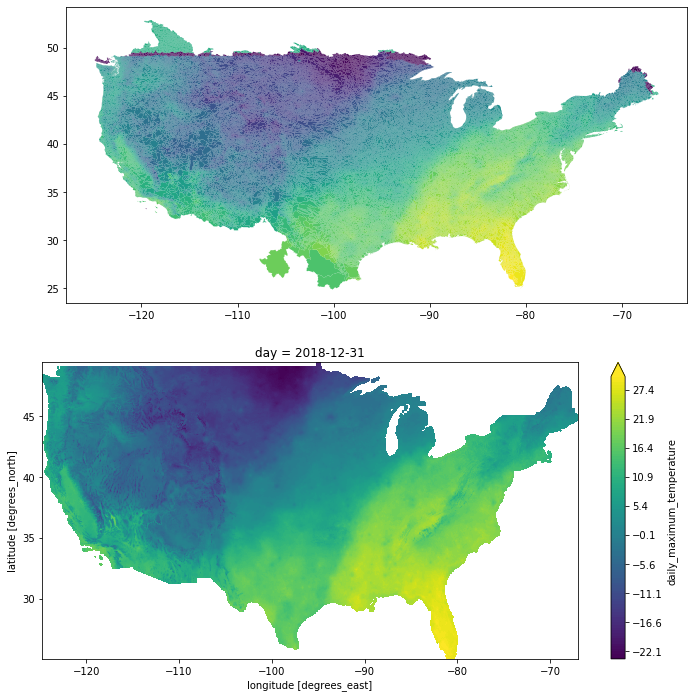

In [8]:
# add tmax column to dataframe
gdf['tmax']=10.0
# gdf.tmax[noint] = 10.0
# print(gdf.tmax[noint])

wght_UofI = pd.read_csv('../pkg/gridmet_weights_hru_v1_1b.csv')
print(wght_UofI.head())

#iterate through hru's, grab all weights associated with hru_id, get total weighted value from netcdf file, assign to tmax
ndata = datahandle.values[dayshape-1,:,:].flatten(order='K')

print(ndata[1000:])

unique_hru_ids = wght_UofI.groupby('nhm_id')
print(len(gdf), len(unique_hru_ids))

def np_get_wval2(grp, ndata):
    mdata = np.ma.masked_array(ndata[grp['grid_ids'].values.astype(int)], np.isnan(ndata[grp['grid_ids'].values.astype(int)]))
    return np.ma.average(mdata, weights=grp['w'])
    
# unique_hru_ids.get_group(gdf['hru_id_nat']).agg({'tmax': np_get_wval(weight_id_rows, ndata)})    
td = np.zeros(len(gdf.index))
for index, row in gdf.iterrows():
#     if not(row['nhm_id'] in noint):
    try: 
        weight_id_rows = unique_hru_ids.get_group(row['nhm_id'])
        td[index] = np_get_wval2(weight_id_rows, ndata) - 273.5
    except KeyError:
        td[index] = 10.0
            
            
#         gdf['tmax'][index] = np_get_wval2(weight_id_rows, ndata)
#     else:
#         td[index] = 10.0

gdf['tmax'] = td.tolist()
# gdf['tmax'].fillna(0.0)

print('min/max', gdf['tmax'].min(), gdf['tmax'].max())

f, ax = plt.subplots(2, figsize=(12,12))
gdf.plot(ax=ax[0], column = 'tmax',linewidth=0., edgecolor='white')
ptmax = ds.daily_maximum_temperature -273.5
ptmax_1 = ptmax.isel(day=dayshape-1)
lvs = np.arange(gdf['tmax'].min(), gdf['tmax'].max(), 0.5)
ptmax_1.plot(ax=ax[1], levels=lvs, cmap='viridis')

In [ ]:
print(unique_hru_ids.head())

print(len(td))
print(len(gdf))
print(gdf.head())
print(td[0])
print(unique_hru_ids.get_group(gdf.iloc[0]['nhm_id']))
print('true or false', gdf.iloc[0]['nhm_id'] in unique_hru_ids)


# Perform zonal stats using rasterstats with the geotiff raster and hru shapefile

In [ ]:
import geoplot as gplt

print(transform)
with rasterio.open(r'test1.tif') as src:
    transform = src.meta['transform']
    print(type(transform), src.meta)
    array = src.read(1)

hrudata = gpd.GeoDataFrame.from_file(r'nhru_02.shp')

stats = zonal_stats(hrudata, array, transform=transform.to_gdal(), prefix='tmax_', all_touched=True)
statsdf = pd.DataFrame(stats)
src.close()

print(statsdf.head())

zonalhru = hrudata.join(statsdf)

# # print(stats)
# # newhru = hrudata.join(gpd.DataFrame(stats))
# # print(newhru.head())
zonalhru.__class__ = gpd.GeoDataFrame
zonalhru.crs={}
zonalhru.set_geometry('geometry')
# ax = gplt.pointplot(zonalhru['mean'])
# gplt.polyplot()
# geoplot.choropleth(zonalhru, hue='mean', cmap='viridis', k = 20, 
#                 linewidth=0.5, legend=True)
zonalhru.plot(column='tmax_mean', cmap='viridis')

# Alternative Rasterstats method: 
* https://geohackweek.github.io/vector/06-geopandas-advanced/

In [ ]:
import rasterio
import rasterio.plot as rioplot
import cartopy.crs as ccrs

# print(transform)
with rasterio.open(r'test1.tif') as src:
    transformb = src.meta['transform']
    print(type(transformb), src.meta)
    array = src.read(1)
rasterdata = rasterio.open(r'test1.tif')
tmp = rioplot.show(rasterdata, with_bounds=True, cmap='viridis', extent=([-82, -70, 36, 46]))
print(tmp.axis)
tmp.set_xlim([-82, -70])
tmp.set_ylim([36, 46])
hrudata = gpd.GeoDataFrame.from_file(r'nhru_02.shp')

stats = zonal_stats(hrudata, r'test1.tif', transform=transformb.to_gdal(), prefix='tmax_', 
                    all_touched=True, geojson_out=True)
# statsdf = pd.DataFrame(stats)
# src.close()
stats_gdf = gpd.GeoDataFrame.from_features(stats)
print(stats_gdf.head())
extent=([-82, -70, 36, 46])
f, ax = plt.subplots(1, figsize=(8,6))
ax.set_title("max temp")
stats_gdf.plot(ax=ax, column='tmax_mean', scheme='Equal_Interval', k=10, 
                   cmap='viridis', linewidth=0.25, edgecolor='black', 
                   legend=True, legend_kwds={'loc': 'upper left'})

# Alternative Rasterstats by opening netcdf directly rather than first saving to geotif

In [ ]:
import rasterio
import rasterio.plot as rioplot
import cartopy.crs as ccrs

print(os.getcwd())
with rasterio.open(r'../Data/new.nc', driver='NetCDF') as src:
    transformb = src.meta['transform']
    print(type(transformb), src.meta)
    array = src.read(1)
rasterdata = rasterio.open(r'test1.tif')
tmp = rioplot.show(rasterdata, with_bounds=True, cmap='viridis', extent=([-82, -70, 36, 46]))
print(tmp.axis)
tmp.set_xlim([-82, -70])
tmp.set_ylim([36, 46])
hrudata = gpd.GeoDataFrame.from_file(r'nhru_02.shp')

stats = zonal_stats(hrudata, r'test1.tif', transform=transformb.to_gdal(), prefix='tmax_', 
                    all_touched=True, geojson_out=True)
# statsdf = pd.DataFrame(stats)
# src.close()
stats_gdf = gpd.GeoDataFrame.from_features(stats)
print(stats_gdf.head())
extent=([-82, -70, 36, 46])
f, ax = plt.subplots(1, figsize=(8,6))
ax.set_title("max temp")
stats_gdf.plot(ax=ax, column='tmax_mean', scheme='Equal_Interval', k=10, 
                   cmap='viridis', linewidth=0.25, edgecolor='black', 
                   legend=True, legend_kwds={'loc': 'upper left'})

In [ ]:
print(len(stats_gdf.index))

# write netcdf file using netcdf4
* https://github.com/Unidata/netcdf4-python/blob/master/examples/writing_netCDF.ipynb

In [ ]:
import netCDF4
try: ncfile.close() # just to be safe, make sure dataset is not already open.
except: pass
ncfile = netCDF4.Dataset('new.nc',mode='w',format='NETCDF4_CLASSIC')

# Global Attributes
ncfile.Conventions = 'CF-1.8'
ncfile.featureType = 'timeSeries'
ncfile.history = ''

sp_dim = len(stats_gdf.index)
hruid_dim = ncfile.createDimension('hruid', sp_dim)     # hru_id
time_dim = ncfile.createDimension('time', None) # unlimited axis (can be appended to).
for dim in ncfile.dimensions.items():
    print(dim)

#Create Variables
time = ncfile.createVariable('time', np.int, ('time', ))
time.long_name = 'time'
time.standard_name = 'time'
time.units = 'days since '+'base_date'+' 00:00'+'time_zone'

hru = ncfile.createVariable('hruid', np.int, ('hruid', ))
hru.cf_role = 'timeseries_id'
hru.long_name = 'local model hru id'

lat = ncfile.createVariable('hru_lat', np.float32, ('hruid',))
lat.long_name = 'Latitude of HRU centroid'
lat.units = 'degrees_north'
lat.standard_name = 'hru_latitude'

lon = ncfile.createVariable('hru_lon', np.float32, ('hruid',))
lon.long_name = 'Longitude of HRU centroid'
lon.units = 'degrees_east'
lon.standard_name = 'hru_longitude'

prcp = ncfile.createVariable('prcp', np.float32, ('time', 'hruid'))
prcp.long_name = 'Daily precipitation rate'
prcp.units = 'mm/day'
prcp.standard_name = 'lwe_precipitation_rate'

tmax = ncfile.createVariable('tmax', np.float32, ('time', 'hruid'))
tmax.long_name = 'Maximum daily air temperature'
tmax.units = 'degree_Celsius'
tmax.standard_name = 'maximum_daily_air_temperature'

tmin = ncfile.createVariable('tmin', np.float32, ('time', 'hruid'))
tmin.long_name = 'Minimum daily air temperature'
tmin.units = 'degree_Celsius'
tmin.standard_name = 'minimum_daily_air_temperature'

# fill variables with available data
def getXY(pt):
    return (pt.x, pt.y)
centroidseries = stats_gdf['geometry'].centroid
tlon, tlat = [list(t) for t  in zip(*map(getXY, centroidseries))]
# print(lon, lat)
lon[:] = tlon
lat[:] = tlat
hru[:] = stats_gdf['hru_id_nat'].values
# print(hruid)
tmax[0,:] = stats_gdf['tmax_mean'].values

print(ncfile)
ncfile.close(); print("dataset is closed")
